# Principles of Data Science

### Lecture 24: Projecting joint p.d.f components

_MPhil in Data Intensive Science_

**University of Cambridge**

<h2 style="color: blue">Matt Kenzie</h2>

[mk652@cam.ac.uk](mailto:mk652@cam.ac.uk)

*The following lines **should** be included by default in all my lecture notebooks*

- Display matplotlib plots interactively

In [1]:
%matplotlib widget

- Do not display the canvas title of the plot (default is "Figure N")

In [2]:
%%html
<style>
div.jupyter-widgets.widget-label {display: none;}
</style>

- Import standard modules

In [3]:
import numpy as np
np.random.seed(210187)
import matplotlib.pyplot as plt
plt.style.use('../mphil.mplstyle')

## Cheers Mate!

- Many thanks to **Mate Balogh** who has helped put together some more practise and mock questions
    - I will distribute these later this week
- You probably all owe him a beer

<img src="plots/cheers_mate.png">

## Projecting joint p.d.f components

- Today's lecture covers (*a topic rather close to my heart*) projecting joint p.d.f components

- Learning objectives:
    - Understand the available options and limitations of projecting joint p.d.f. components
    - Be familiar with the *sWeight* and *COW* methods

## Setting up the problem

- Common to *discriminate* between peaking signal and smooth background in some dimension
    - the <font color="blue">discriminant variable(s)</font>
    
- But often want to understand the properties of the signal in some other dimension
    - the <font color="blue">control variable(s)</font>

<img src="plots/sweights_example.png">

- But this is fine right?
- Just fit in multi-dimensions with a joint p.d.f
- The issue arises if we don't know the distribution of the background in the control dimensions
    - which we often don't


## The sliced fit option

- A reasonable (but sub-optimal) approach is to fit the *discriminant* variable in **slices** of the control variable
- This requires:
    - That the discriminant and control variables are **independent**
    - Sufficient statistics to slice up the data
    
- This approach is not very statistically powerful
    
<br>

- <font color="green">*Some visualisations and discussion in the lecture*</font>

## The *sWeight* approach

- <font color="green">*See derivation in the lectures*</font> 

# <font color="darkred">*Musical interlude...*</font>

## An *sWeight* example

- The classic smootly falling and peaking background case in the **discriminant** variable
- Have a look at an oscillating shape in the **control** variable

In [4]:
# just a copy/paste of my previously shown accept_reject generator

from scipy.optimize import brute, minimize

def accept_reject_1d( func, xrange, size=1, fmax=None, ret_fmax=False, seed=None, stats=False, verbose=False ):
    """A simple function to run accept-reject generation.

    Parameters
    ----------
    func : callable
        A callable function which accepts one argument x and
        returns the function which you want to generate from.
        Note that for accept-reject there is no requirement
        that is normalised
    xrange : tuple or list
        Must be a two element tuple or list containing the
        range of x values to generate in
    size : int, optional
        Number of events to generate
    fmax : float, optional
        If already known you can provide the maximum value of
        the function. This speeds up generation a bit because
        the algorithm can skip finding the maximum
    stats : bool, optional
        If True then track the generation efficiency statistics
        and return them

    Returns
    -------
    x : array
        an array of generated x values
    fmax : float, optional
        if ret_fmax=True then will also return the fmax found
    stats : tuple, optional
        if stats=True will also return the accept_eff and reject_eff

    """

    if fmax is None:
        if verbose:
            print('a/r looking for fmax... ', end='')
        # global
        f_to_min = lambda x: -func(x)
        x0 = brute( f_to_min, [xrange] )[0]
        # local
        x0 = minimize( f_to_min, x0=x0, bounds=[xrange] ).x[0]
        fmax = func(x0)
        if verbose:
            print('DONE. fmax=', fmax)

    if seed is not None:
        np.random.seed(seed)

    res = []
    nrej = 0
    while len(res)<size:

        # generate uniform random in xrange
        x = np.random.uniform(*xrange)

        # compute the value of the func at this x
        fval = func(x)

        # check it's not negative
        if fval < 0:
            raise RuntimeError(f'Accept-reject found a negative function value. p.d.f.s cannot be negative. Bailing out')

        # check it's not bigger than fmax
        if fval > fmax:
            fmax = fval
            raise RuntimeError(f'Accept-reject found a larger function value than was provided {fval}. Updating fmax and bailing out')

        # now generate random between [0, fmax]
        ftest = np.random.uniform(0, fmax )

        # if ftest larger than fval reject else accept
        if ftest <= fval:
            res.append(x)
            if verbose:
                print(f'Accept-rejecting {len(res)} / {size}', end='\r')
        # this just counts the number of rejections
        else:
            nrej += 1

    if stats:
        ntot = size + nrej
        rej_eff = nrej / ntot
        acc_eff = size / ntot
    
    if verbose:
        print('Accept-rejecting DONE         ')
    if ret_fmax:
        if stats:
            return res, fmax, acc_eff, rej_eff
        else:
            return res, fmax
    else:
        if stats:
            return res, acc_eff, rej_eff
        else:
            return res


In [5]:
# generate the sample
from numba_stats import norm, expon
xrange = (0, 10)
yrange = (-np.pi, np.pi)

x = np.linspace(*xrange, 200)
y = np.linspace(*yrange, 200)

N = 5000
lb = 4
mu = 5
sg = 1
ba = 0.6
bb = 0.2
bc = 0.4
sp = 1.2
f  = 0.6

Ns = int( f*N )
Nb = N - Ns
Ns = np.random.poisson(Ns)
Nb = np.random.poisson(Nb)

sgenX = lambda x: norm.pdf(x, mu, sg)
bgenX = lambda x: expon.pdf(x, xrange[0], lb )
sgenY = lambda x: np.cos(sp*x)**2
bgenY = lambda x: bc+bb*(1-np.cos(ba*x))
 
sX = accept_reject_1d( sgenX, xrange, size=Ns )
bX = accept_reject_1d( bgenX, xrange, size=Nb )
sY = accept_reject_1d( sgenY, yrange, size=Ns )
bY = accept_reject_1d( bgenY, yrange, size=Nb )

dsetx = np.concatenate( [bX, sX] )
dsety = np.concatenate( [bY, sY] )
dset = np.stack( [dsetx, dsety], axis=1 )

/Users/matt/miniconda3/envs/mphil/lib/python3.9/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


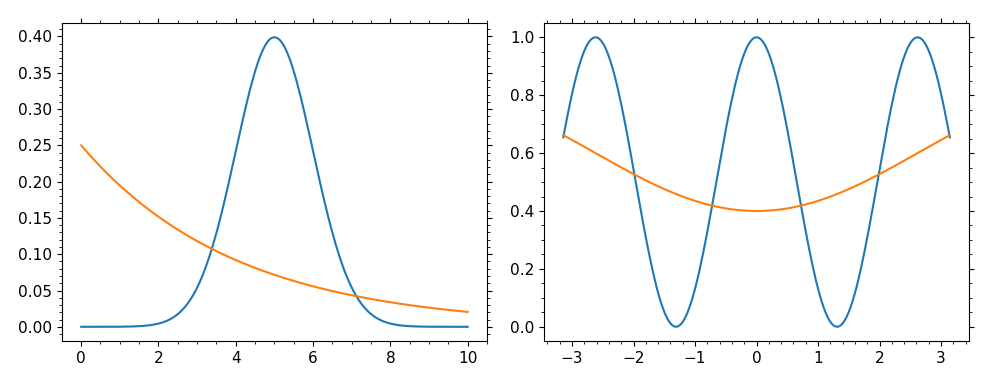

In [6]:
# plot the functions for sanity
fig, ax = plt.subplots(1, 2, figsize=(0.8*12.4, 0.8*4.8) )
ax[0].plot(x, sgenX(x) )
ax[0].plot(x, bgenX(x) )
ax[1].plot(y, sgenY(y) )
ax[1].plot(y, bgenY(y) )

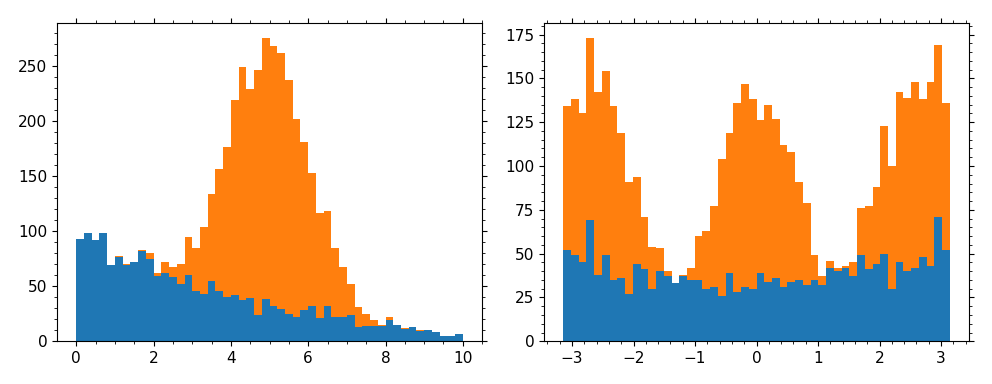

In [7]:
# plot the sample

fig, ax = plt.subplots(1, 2, figsize=(0.8*12.4, 0.8*4.8) )
_ = ax[0].hist( [bX, sX], stacked=True, range=xrange, bins=50)
_ = ax[1].hist( [bY, sY], stacked=True, range=yrange, bins=50)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -5.554e+04                 │              Nfcn = 135              │
│ EDM = 2.44e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Ns   │  3.18e3   │  0.08e3   │            │            │         │         │       │
│ 1 │ Nb   │  1.83e3   │  0.07e3   │            │            │         │         │       │
│ 2 │ mu   │   4.976   │   0.024   │            │            │         │         │       │
│ 3 │ sg   │   1.060   │   0.024   │            │            │         │         │       │
│ 4 │ lb   │   3.72    │   0.19    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        Ns        Nb        mu        sg        lb │
├────┼───────────────────────────────────────────────────┤
│ Ns │  6.15e+03 -2.98e+03    -0.232      0.88      -6.5 │
│ Nb │ -2.98e+03  4.81e+03     0.232     -0.88       6.5 │
│ mu │    -0.232     0.232  0.000595 -0.000103 -0.000387 │
│ sg │      0.88     -0.88 -0.000103  0.000586  -0.00178 │
│ lb │      -6.5       6.5 -0.000387  -0.00178    0.0351 │
└────┴───────────────────────────────────────────────────┘

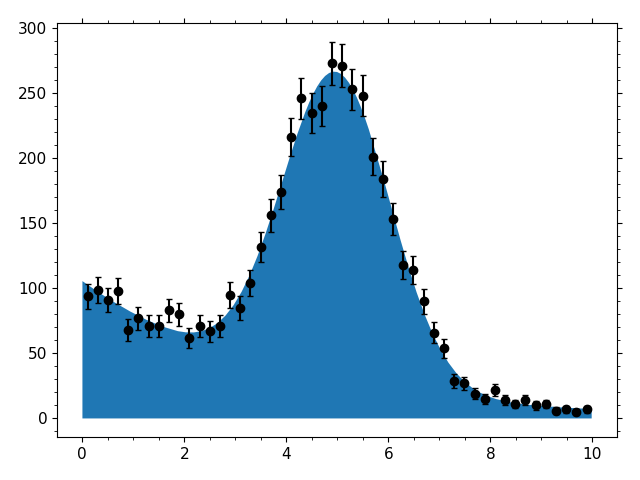

In [8]:
# now we need to fit in the discriminant 
from numba_stats import norm as fnorm, expon as fexpon
from iminuit import Minuit, cost

def spdf(x, mu, sg):
    return fnorm.pdf(x, mu, sg) / np.diff( fnorm.cdf(xrange, mu, sg) )

def bpdf(x, lb):
    return fexpon.pdf(x, xrange[0], lb) / np.diff( fexpon.cdf(xrange, xrange[0], lb) )

def tmodel(x, Ns, Nb, mu, sg, lb, comps=['S','B']):
    res = np.zeros_like(x)
    if 'S' in comps:
        res = res + Ns*spdf(x, mu, sg)
    if 'B' in comps:
        res = res + Nb*bpdf(x, lb)
    return res 

def tdensity(x, Ns, Nb, mu, sg, lb):
    return Ns+Nb, tmodel(x, Ns, Nb, mu, sg, lb)

n2ll = cost.ExtendedUnbinnedNLL( dset[:,0], tdensity )
mi = Minuit( n2ll, Ns=f*N, Nb=(1-f)*N, mu=mu, sg=sg, lb=lb)
mi.migrad()
mi.hesse()
display(mi)

fig, ax = plt.subplots()
mi.visualize()



- Well that seems to have gone quite well
- Now let's see what the weight projections look like

In [9]:
from sweights import SWeight

sf = lambda x: spdf(x, mi.values['mu'], mi.values['sg'])
bf = lambda x: bpdf(x, mi.values['lb'])
sy = mi.values['Ns']
by = mi.values['Nb']

sweighter = SWeight( dset[:,0], pdfs=[sf,bf], yields=[sy,by], discvarranges=(xrange,) )

Initialising sweight with the summation method:
    PDF normalisations:
	 0 1.0000000000000002
	 1 0.9999999999999999
    W-matrix:
	[[2.58508322e-04 9.76750758e-05]
	 [9.76750758e-05 3.76366528e-04]]
    A-matrix:
	[[ 4288.90817516 -1113.06240216]
	 [-1113.06240216  2945.8476602 ]]
    Integral of w*pdf matrix (should be close to the
                identity):
	[[9.99808124e-01 4.15912260e-04]
	 [2.47290173e-04 9.99660235e-01]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |  3175.6929 |  3175.6929 |    -0.00% |
	  1        |  1832.6226 |  1832.6226 |     0.00% |


- Let's take a look at the weight functions themselves

Text(0.5, 0, '$X$')

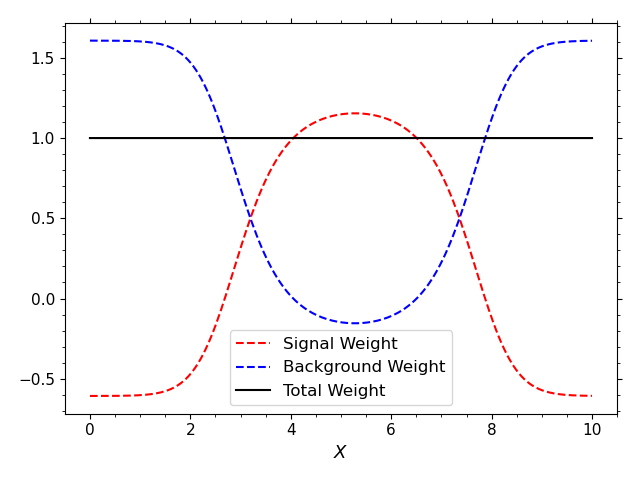

In [10]:
fig, ax = plt.subplots()
sw = sweighter.get_weight(0,x)
bw = sweighter.get_weight(1,x)
ax.plot(x, sw, 'r--', label='Signal Weight')
ax.plot(x, bw, 'b--', label='Background Weight')
ax.plot(x, sw+bw, 'k-', label='Total Weight')
ax.legend()
ax.set_xlabel('$X$')

- Then apply these weights to our dataset as a function of $Y$

Text(0.5, 0, '$Y$')

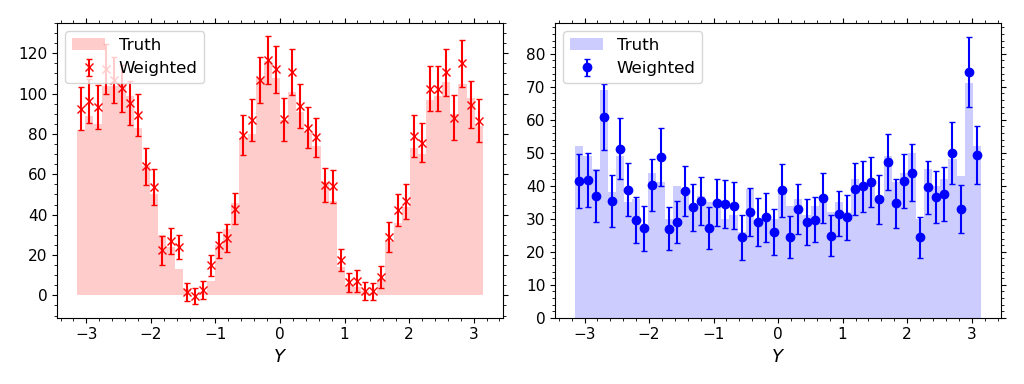

In [11]:
sw = sweighter.get_weight(0, dset[:,0])
bw = sweighter.get_weight(1, dset[:,0])

ysw, ye = np.histogram( dset[:,1], bins=50, range=yrange, weights=sw )
ybw, ye = np.histogram( dset[:,1], bins=50, range=yrange, weights=bw )

ysw2, ye = np.histogram( dset[:,1], bins=50, range=yrange, weights=sw**2 )
ybw2, ye = np.histogram( dset[:,1], bins=50, range=yrange, weights=bw**2 )

cy = 0.5*(ye[1:]+ye[:-1])

fig, ax = plt.subplots(1, 2, figsize=(0.8*12.8, 0.8*4.8))

ax[0].errorbar( cy, ysw, ysw2**0.5, fmt='rx', label='Weighted' )
ax[0].hist( sY, bins=50, range=yrange, fc='r', alpha=0.2, label='Truth' )
ax[0].legend()
ax[1].errorbar( cy, ybw, ybw2**0.5, fmt='bo', label='Weighted' )
ax[1].hist( bY, bins=50, range=yrange, fc='b', alpha=0.2, label='Truth' )
ax[1].legend()

ax[0].set_xlabel('$Y$')
ax[1].set_xlabel('$Y$')


- I can project out the **pure** signal or background component
- Without ever needing a description of any of their densities in the control variable(s)
- I can then fit this with some distribution if I desire

## Custom Orthogonal Weight functions (COWs)

- So what do we do in the case when the joint p.d.f doesn't factorise?

- Can exploit **Kolmogorov-Arnold representation theorem**
    - any joint p.d.f can be represented by a finite sum of factorising terms 
    
$$ f(X,Y) = \sum_k^n z_k g_k(X)h_k(Y) \quad \text{with} \quad \sum_k^n z_k = 1 $$

- Can then assign any number of terms to the components (e.g. signal and background) of the total

- Any single component of $f(X,Y)$ is isolated by a weight function

$$ w_k(X) = \sum_{l}^{n} \frac{A_{kl} g_l(X)}{I(X)} \qquad \text{with} \qquad A_{kl}^{-1} = W_{kl} = \int \frac{g_k(X) g_k(X)}{I(X)} dX $$

- $I(X)$ is called the **variance function** and can be any non-zero function
- $g_k$ are called the **basis functions**
- Between them they, for any problem, determine a set of **Custom Orthogonal Weight functions** (COWs)
- It follows that

    - **Unitary condition**
    $$ \sum_{i=0}^{n} A_{ki}W_{ij} = \delta_{kj} $$

    - **Ortho-normality condition**
    $$ \int \frac{w_k(X) g_l(X)}{I(x)} dX = \delta_{kl} $$

## Something light-hearted to finish

- So why are they called **Custom Orthogonal Weight functions**?

<img src="plots/cow_bet_1a.png" width="800">

<img src="plots/cow_bet_1b.png" width="800">

<img src="plots/cow_bet_2.png" width="700">

<img src="plots/cow_paper.png" width="800">

<img src="plots/cows_to_steaks.png" width="800">

# End of Lecture 24

By the end of this lecture you should:
- Understand the available options and limitations of projecting joint p.d.f. components
- Be familiar with the *sWeight* and *COW* methods

# End of Course

- Thanks (and well done) for making it to the end!
- I look forward to reading your coursework assignments
- Best of luck in the exam(s) and the rest of the course
- Hope to see some of you next term in the *Applications of DIS to High Energy Physics*